In [19]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from langchain.tools import tool

from pydantic import BaseModel, Field
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
from langgraph.graph.message import add_messages
import sqlite3

DB_FILE = 'gdpr_sections.db'



load_dotenv()



True

TypeError: BaseTool.__call__() missing 1 required positional argument: 'tool_input'

In [8]:

try:
    with sqlite3.connect('gdpr_sections.db') as connection:
        cursor = connection.cursor()

        sql_query = "SELECT * FROM sections"

        cursor.execute(sql_query,)
        results = cursor.fetchall()


        if results is None:
                print("Nothing found")

        else:
            for result in results:
                print(result)

except sqlite3.IntegrityError as e:
    print(f"Error: Integrity constraint violated - {e}")

except sqlite3.OperationalError as e:
    print(f"Error: Operational issue - {e}")

except sqlite3.Error as e:
    print(f"Error: Generic Sqlite3 error - {e}")        

except Exception as e:
    print(f"An unexpected error occurred: {e}")

(1, '(1) The protection of natural persons in relation to the processing of personal data is a fundamental right. Article 8(1) of the Charter of Fundamental Rights of the European Union (the ‘Charter’) and Article 16(1) of the Treaty on the Functioning of the European Union (TFEU) provide that everyone has the right to the protection of personal data concerning him or her.')
(2, '(2) The principles of, and rules on the protection of natural persons with regard to the processing of their personal data should, whatever their nationality or residence, respect their fundamental rights and freedoms, in particular their right to the protection of personal data. This Regulation is intended to contribute to the accomplishment of an area of freedom, security and justice and of an economic union, to economic and social progress, to the strengthening and the convergence of the economies within the internal market, and to the well-being of natural persons.')
(3, '(3) Directive 95/46/EC of the Euro

E0000 00:00:1767631048.073149   15300 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


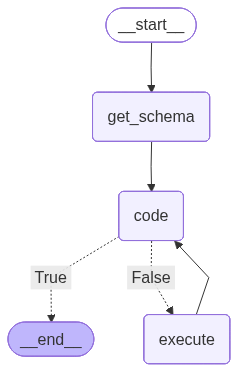

In [21]:
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)


# STATE
class QueryState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    database_name: str

# TOOLS
import os, subprocess, sys, contextlib, io, json
from codeact_db import select, insert_or_update, get_db_schema

@tool
def execute_code(code: str = Field(description="Code to be executed."),
                 state: Annotated[QueryState, InjectedState] = None
                 ) -> str:
    """
    Execute the Python code and returns the output or error message.
    You have access to a library for database access.  You have two functions:
    - select(query: str, parameters: Sequence[Any] | None = None)
    - insert_or_update(query: str, parameters: Sequence[Any] | None = None)
    You MUST set db_name argument to the variable 'database_name'.
    """
    """Run Python source in a fresh subprocess that inherits the current environment."""
    header = f"from codeact_db import select, insert_or_update\nimport os\nprint('ENVS:', os.environ)\n"
    code = header + "\n" + code
    envs = os.environ.copy()
    envs["DB_NAME"]=DB_FILE
    if not isinstance(code, str):
        raise TypeError("code must be a string")
    completed = subprocess.run(
        [sys.executable, "-c", code],
        capture_output=True,
        text=False,
        check=False,
        env=envs,
    )
    stdout = completed.stdout.decode("utf-8", errors="replace") if completed.stdout else ""
    stderr = completed.stderr.decode("utf-8", errors="replace") if completed.stderr else ""
    if completed.returncode != 0:
        detail = f"{stdout}{stderr}".strip()
        return f"Process exited with status {completed.returncode}." + (f"\n{detail}" if detail else "")
    return stdout if stdout else (stderr if stderr else "No output")



# NODES
def get_schema_node(state: QueryState) -> dict:
  
    schema = get_db_schema(state.database_name)
    message = AIMessage(content=f"<SCHEMA>:\n {json.dumps(schema)} \n</SCHEMA>\n")
    return {"messages": [message]}

    
def execute_code_node(state: QueryState) -> dict:
    
    result = llm.bind_tools(tools=[execute_code]).invoke(state.messages)
    return {"messages": result}

# GRAPH
graph = StateGraph(QueryState)
graph.add_node("get_schema", get_schema_node)
graph.add_node("code", execute_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "get_schema")
graph.add_edge("get_schema", "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"})
graph.add_edge("execute", "code")

# compile graph
query_graph = graph.compile()
query_graph


In [22]:
messages = [SystemMessage(content="""
You are an expert Python programmer and database analyst.
You are a CodeAct agent for interacting with a database.
You MUST use these functions to interact with the database:
    - select(query: str, parameters: Sequence[Any] | None = None)
    - insert_or_update(query: str, parameters: Sequence[Any] | None = None)
Read the Schema provided to understand the database structure.

"""),
                HumanMessage(content="""
                             Get all the sections
                             """)
    ]

In [23]:
result = query_graph.invoke(QueryState(messages=messages, database_name=DB_FILE))
print(result['messages'][-1].content)

Here are all the sections from the database:

*   **id**: 1, **content**: (1) The protection of natural persons in relation to the processing of personal data is a fundamental right. Article 8(1) of the Charter of Fundamental Rights of the European Union (the ‘Charter’) and Article 16(1) of the Treaty on the Functioning of the European Union (TFEU) provide that everyone has the right to the protection of personal data concerning him or her.
*   **id**: 2, **content**: (2) The principles of, and rules on the protection of natural persons with regard to the processing of their personal data should, whatever their nationality or residence, respect their fundamental rights and freedoms, in particular their right to the protection of personal data. This Regulation is intended to contribute to the accomplishment of an area of freedom, security and justice and of an economic union, to economic and social progress, to the strengthening and the convergence of the economies within the internal m